# Step 3: Data Preparation

# Table of Contents

1. [Drop highly correlated columns](#drop-highly-correlated-columns)
2. [Handling Missing values](#handling-missing-values)
3. [Outlier Handling](#outlier-handling)
4. [Encoding of Categorial Variables](#encoding-of-categorial-variables)
5. [Scaling for Machine Learning](#scaling-for-machine-learning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.impute import KNNImputer
import pycountry_convert as pc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from scipy.stats import skew
import os

import warnings
warnings.filterwarnings("ignore")


In [2]:
df_who = pd.read_csv('./Life_Expectancy_data.csv')
df_who.shape

(2938, 22)

In [3]:
# Clean column names by removing leading and trailing whitespace
df_who.columns = df_who.columns.str.strip()

#### Drop Highly Correlated Columns

To ensure the quality of the analysis and avoid multicollinearity, highly correlated columns were removed from the df_who. Specifically, the following columns were dropped:

- **`percentage expenditure`**
- **`thinness 5-9 years`**
- **`infant deaths`**

These columns were identified as having a correlation coefficient above the threshold of 0.85 with other columns in the df_whoset. The decision on which column to drop in each correlated pair is detailed in the report. This decision was based on specific criteria, such as redundancy, domain relevance, or statistical significance, to ensure minimal information loss.

By dropping these columns, we retain the integrity of the df_whoset while minimizing unnecessary redundancy.


In [4]:
# Select only numeric columns from the DataFrame
numeric_df_who = df_who.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df_who.corr()

# Filter columns with a correlation of at least 0.85
threshold = 0.85
high_corr = correlation_matrix[(correlation_matrix >= threshold) & (correlation_matrix < 1.0)]

# Display pairs of columns with high correlation
high_corr_pairs = high_corr.stack()
print(high_corr_pairs)


infant deaths           under-five deaths         0.996629
percentage expenditure  GDP                       0.899373
under-five deaths       infant deaths             0.996629
GDP                     percentage expenditure    0.899373
thinness  1-19 years    thinness 5-9 years        0.939102
thinness 5-9 years      thinness  1-19 years      0.939102
dtype: float64


In [5]:
# Drop the specified columns
columns_to_drop = ['percentage expenditure', 'thinness 5-9 years', 'infant deaths']
df_who = df_who.drop(columns=columns_to_drop)


#### Handling Missing Values

In [6]:
df_who.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   Alcohol                          2744 non-null   float64
 6   Hepatitis B                      2385 non-null   float64
 7   Measles                          2938 non-null   int64  
 8   BMI                              2904 non-null   float64
 9   under-five deaths                2938 non-null   int64  
 10  Polio                            2919 non-null   float64
 11  Total expenditure                2712 non-null   float64
 12  Diphtheria          

In [7]:
missing_values = df_who.isnull().sum()

print(missing_values)
print("Sum of NaNs:", missing_values.sum())

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
Alcohol                            194
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
Income composition of resources    167
Schooling                          163
dtype: int64
Sum of NaNs: 2529


In [8]:
# Percentage of missing values
print((df_who.isnull().sum() / len(df_who)) * 100)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
Alcohol                             6.603131
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: float64


 Check whether certain countries have NaNs for the entire period of the dataset for the columns with a high NaN rate


In [9]:
# Select the columns to analyze for missing values
columns_to_analyze = ['Population', 'Hepatitis B', 'GDP', 'Alcohol', 'Total expenditure']

# Calculate missing values by country for the selected columns
missing_values_by_country = (
    df_who[columns_to_analyze]
    .isnull()
    .groupby(df_who['Country'])
    .sum()
    .sort_values(by=columns_to_analyze, ascending=False)
)

# Convert the result to a DataFrame for further use
missing_values_df = missing_values_by_country.reset_index()

# Display the resulting DataFrame
# print("Missing values by country for selected columns:")
# print(missing_values_df)

missing_values_df.head(50)

,Country,Population,Hepatitis B,GDP,Alcohol,Total expenditure
0,United Kingdom of Great Britain and Northern I...,16,16,16,0,1
1,Somalia,16,13,13,1,16
2,Congo,16,7,16,1,1
3,Democratic Republic of the Congo,16,7,16,1,1
4,The former Yugoslav republic of Macedonia,16,5,16,1,1
5,Democratic People's Republic of Korea,16,3,16,1,16
6,Lao People's Democratic Republic,16,3,16,1,1
7,Saint Vincent and the Grenadines,16,3,16,1,1
8,Viet Nam,16,3,16,1,1
9,Czechia,16,2,16,1,1


Display the countries and the corresponding columns where at least one column has more than 10 missing values

In [10]:
# Filter for countries where any column has more than 10 missing values
countries_with_more_than_10_missing = missing_values_df[
    (missing_values_df.iloc[:, 1:] > 10).any(axis=1)
]

# Identify the columns (features) with more than 10 missing values for each country
countries_with_columns = countries_with_more_than_10_missing.copy()

# Add a new column to list features with >10 missing values for each country
countries_with_columns['Features with >10 Missing'] = countries_with_columns.iloc[:, 1:].apply(
    lambda row: [col for col, val in zip(missing_values_df.columns[1:], row) if val > 10], axis=1
)

# Select only relevant columns for printing
output_df = countries_with_columns[['Country', 'Features with >10 Missing']]

# Print the results
# print(f"Number of countries where at least one column has more than 10 missing values: {len(output_df)}")
# print(output_df)
output_df.head(50)

,Country,Features with >10 Missing
0,United Kingdom of Great Britain and Northern I...,"[Population, Hepatitis B, GDP]"
1,Somalia,"[Population, Hepatitis B, GDP, Total expenditure]"
2,Congo,"[Population, GDP]"
3,Democratic Republic of the Congo,"[Population, GDP]"
4,The former Yugoslav republic of Macedonia,"[Population, GDP]"
5,Democratic People's Republic of Korea,"[Population, GDP, Total expenditure]"
6,Lao People's Democratic Republic,"[Population, GDP]"
7,Saint Vincent and the Grenadines,"[Population, GDP]"
8,Viet Nam,"[Population, GDP]"
9,Czechia,"[Population, GDP]"


In [11]:
# Strip any extra whitespace from column names to ensure consistent access to columns
df_who.columns = df_who.columns.str.strip()

# Fill missing values in critical columns with the median value
# 'Life expectancy': A key target variable for the analysis. Missing values are replaced with the median 
# to avoid introducing bias and because the median is robust to outliers.
df_who['Life expectancy'] = df_who['Life expectancy'].fillna(df_who['Life expectancy'].median())

# 'Adult Mortality': A critical explanatory variable for health outcomes.
# Missing values are replaced with the median to preserve the distribution of the data.
df_who['Adult Mortality'] = df_who['Adult Mortality'].fillna(df_who['Adult Mortality'].median())

# Fill missing values in columns with a low percentage of missing df_who using the median
# These columns have relatively few missing values, so replacing them with the median is efficient 
# and avoids the risk of skewing the df_who.
columns_median = ['Polio', 'Diphtheria', 'BMI', 'thinness  1-19 years', 
                  'thinness 5-9 years', 'Income composition of resources', 'Schooling']
columns_median = [col for col in columns_median if col in df_who.columns]  # Only process existing columns
df_who[columns_median] = df_who[columns_median].fillna(df_who[columns_median].median())

# Apply KNN Imputation for columns with a moderate amount of missing data
# KNN is used because these columns have a higher percentage of missing values, and KNN can estimate
# values by considering similar rows, preserving relationships between variables.
knn_columns = ['Alcohol', 'Total expenditure', 'GDP', 'Hepatitis B', 'Population']
knn_columns = [col for col in knn_columns if col in df_who.columns]  # Only process existing columns
imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors to impute missing values
df_who[knn_columns] = imputer.fit_transform(df_who[knn_columns])

# Check for any remaining missing values to ensure that all NaNs have been addressed
# This step confirms the success of the imputation process.
print(df_who.isnull().sum())

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
Alcohol                            0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
Income composition of resources    0
Schooling                          0
dtype: int64


Note: there are some countries that do not have a single value for the Population, Hepatitis B and GDP columns. As this is beyond the scope of the project, these are not treated optimally, but for future projects it is advisable to merge further data sets from other sources in order to optimize the data quality.
However, it is being considered whether or not those columns should be used as a feature in the upcoming machine learning process.

#### Outlier Handling

During in-depth analyses of the high ratio of missing values in the population column, further anomalies were identified. There are strong fluctuations within a country in the population.

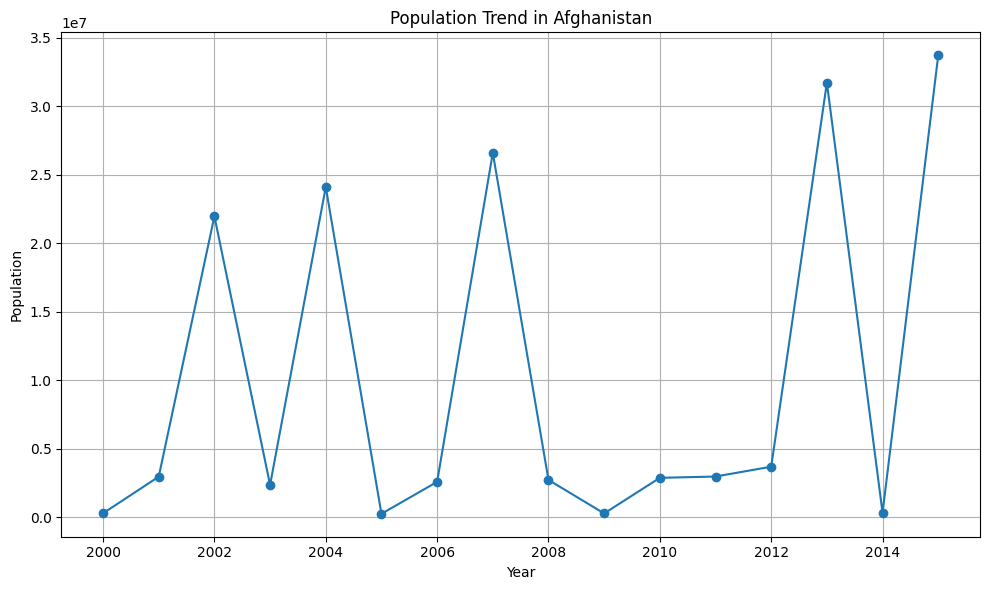

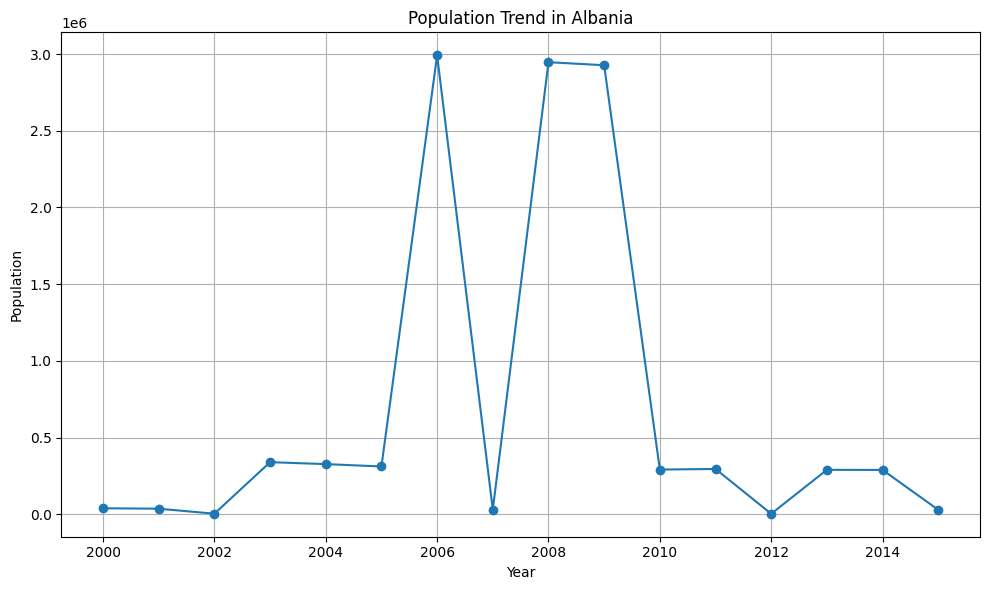

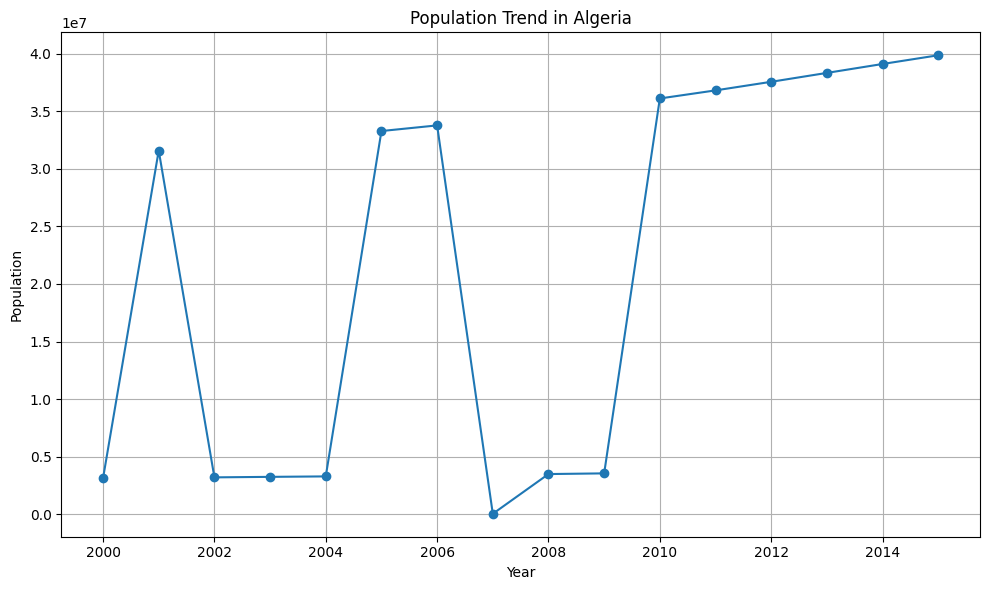

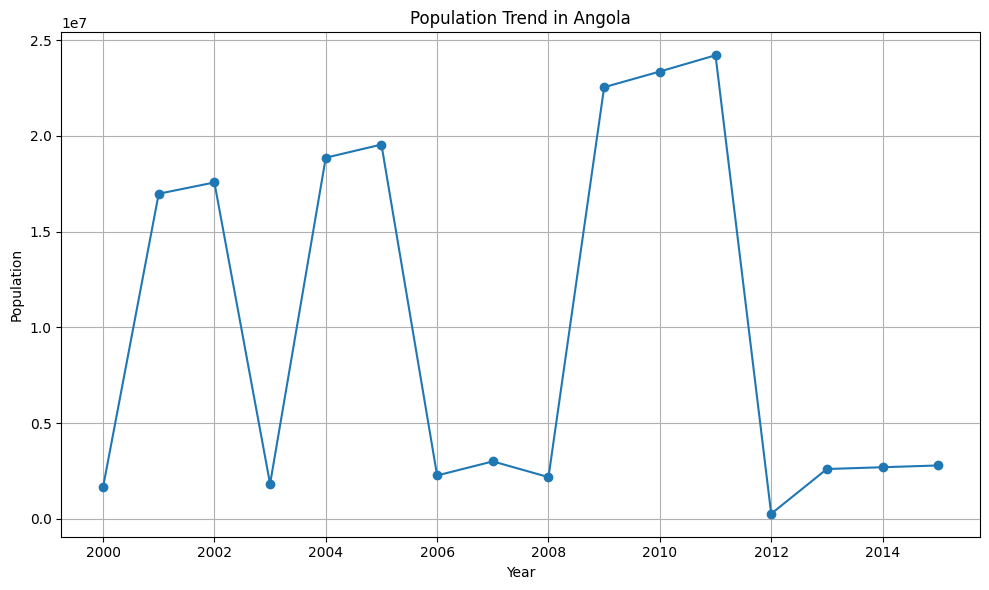

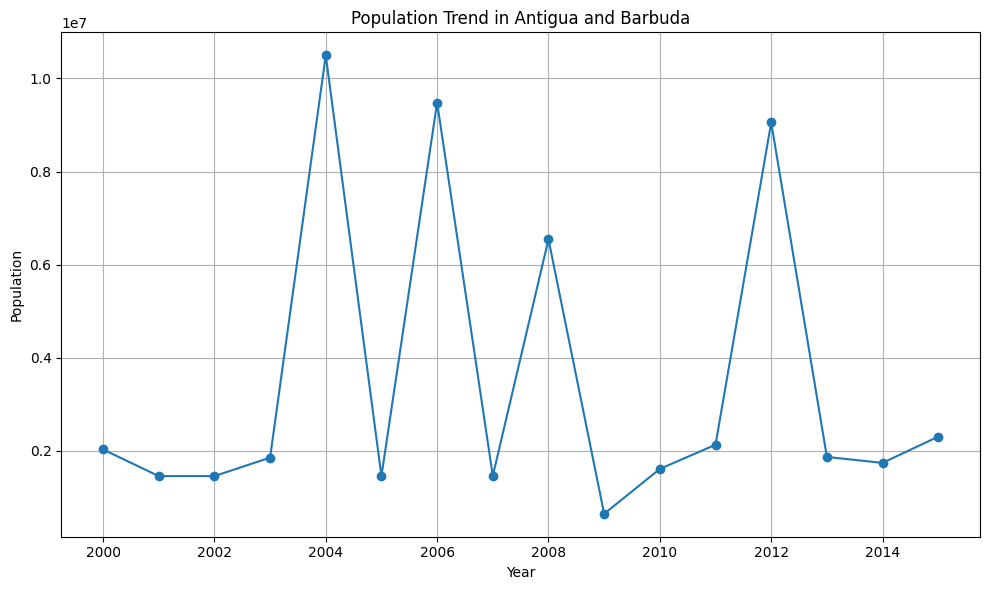

In [12]:
# Get the first 5 unique countries
first_10_countries = df_who['Country'].unique()[:5]

# Loop through each country and create a plot
for country in first_10_countries:
    # Filter the df_whoset for the current country
    country_df_who = df_who[df_who['Country'] == country]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(country_df_who['Year'], country_df_who['Population'], marker='o', linestyle='-', label=country)
    plt.title(f"Population Trend in {country}")
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# Filter the dataset to relevant columns
population_df_who = df_who[['Country', 'Year', 'Population']]

# Remove rows where Population is NaN or 0
population_df_who = population_df_who.dropna(subset=['Population'])
population_df_who = population_df_who[population_df_who['Population'] > 0]

# Ensure the data is sorted by Country and Year
population_df_who = population_df_who.sort_values(by=['Country', 'Year'])

# Calculate metrics per country
country_metrics = population_df_who.groupby('Country').agg(
    Mean_Population=('Population', 'mean'),
    Std_Dev_Population=('Population', 'std')
).reset_index()

# Add Coefficient of Variation (CoV) for each country
country_metrics['CoV (%)'] = (country_metrics['Std_Dev_Population'] / country_metrics['Mean_Population']) * 100

# Calculate Year-over-Year percentage change for each country
population_df_who['YoY_Change (%)'] = population_df_who.groupby('Country')['Population'].pct_change() * 100

# Cap extreme YoY changes for better aggregation
population_df_who['YoY_Change (%)'] = population_df_who['YoY_Change (%)'].clip(lower=-500, upper=500)

# Aggregate mean YoY change for each country
yoy_mean_change = population_df_who.groupby('Country')['YoY_Change (%)'].mean().reset_index()
yoy_mean_change.columns = ['Country', 'Mean_YoY_Change (%)']

# Merge metrics into a single DataFrame
country_metrics = pd.merge(country_metrics, yoy_mean_change, on='Country')

# Global KPIs
mean_cov = country_metrics['CoV (%)'].mean()
mean_yoy_change = country_metrics['Mean_YoY_Change (%)'].mean()
high_cov_percentage = (country_metrics['CoV (%)'] > 20).mean() * 100  # % of countries with high CoV

# Print KPIs
print("=== Global KPIs for Population Variability ===")
print(f"Mean Coefficient of Variation (CoV): {mean_cov:.2f}%")
print(f"Mean Year-over-Year Change (YoY): {mean_yoy_change:.2f}%")
print(f"Percentage of Countries with High CoV (>20%): {high_cov_percentage:.2f}%")


=== Global KPIs for Population Variability ===
Mean Coefficient of Variation (CoV): 105.37%
Mean Year-over-Year Change (YoY): 110.31%
Percentage of Countries with High CoV (>20%): 94.82%


In [14]:
# Step 1: Calculate population metrics per country
population_metrics = df_who.groupby('Country').agg(
    Mean_Population=('Population', 'mean'),
    Std_Dev_Population=('Population', 'std'),
    Min_Population=('Population', 'min'),
    Max_Population=('Population', 'max'),
).reset_index()

# Step 2: Calculate Coefficient of Variation (CoV) for each country
population_metrics['CoV (%)'] = (
    population_metrics['Std_Dev_Population'] / population_metrics['Mean_Population']
) * 100

# Step 3: Identify countries with extreme variability or unrealistic values
extreme_cases = population_metrics[
    (population_metrics['CoV (%)'] > 200) |  # Extremely high variability
    (population_metrics['Min_Population'] < 100)  # Unrealistic population
]

# Step 4: Extract rows from the data for the identified countries
extreme_population_df_who = df_who[df_who['Country'].isin(extreme_cases['Country'])]

# Step 5: Sort for better inspection and create the DataFrame
extreme_population_df = extreme_population_df_who.sort_values(by=['Country', 'Year'])

# Select only the relevant columns: Country, Year, Population
extreme_population_df = extreme_population_df[['Country', 'Year', 'Population']]

# Display the simplified DataFrame
display(extreme_population_df)


,Country,Year,Population
127,Australia,2000,19153.0
126,Australia,2001,19413.0
125,Australia,2002,196514.0
124,Australia,2003,198954.0
123,Australia,2004,21274.0
...,...,...,...
2798,United States of America,2011,8085948.4
2797,United States of America,2012,10299868.4
2796,United States of America,2013,11664416.0
2795,United States of America,2014,7884253.6


The analysis of population variability across countries reveals significant fluctuations, as evidenced by a high average Coefficient of Variation (CoV) and substantial Year-over-Year (YoY) changes. These findings suggest possible data quality issues, such as outliers, unrealistic minimum values, or reporting inconsistencies, particularly for smaller countries where minor changes lead to large percentage shifts.

Potential Implications:
Data Quality Concerns: Large variability could indicate errors in population records or missing data for certain years.


Real-World Factors: Fluctuations may reflect migration, conflicts, or demographic shifts.


Analysis Adjustments: Future studies should account for these anomalies by cleaning the dataset, include other appropriate datasets, excluding outliers, or normalizing for country size to ensure accurate insights.

Comparison of outlier handling

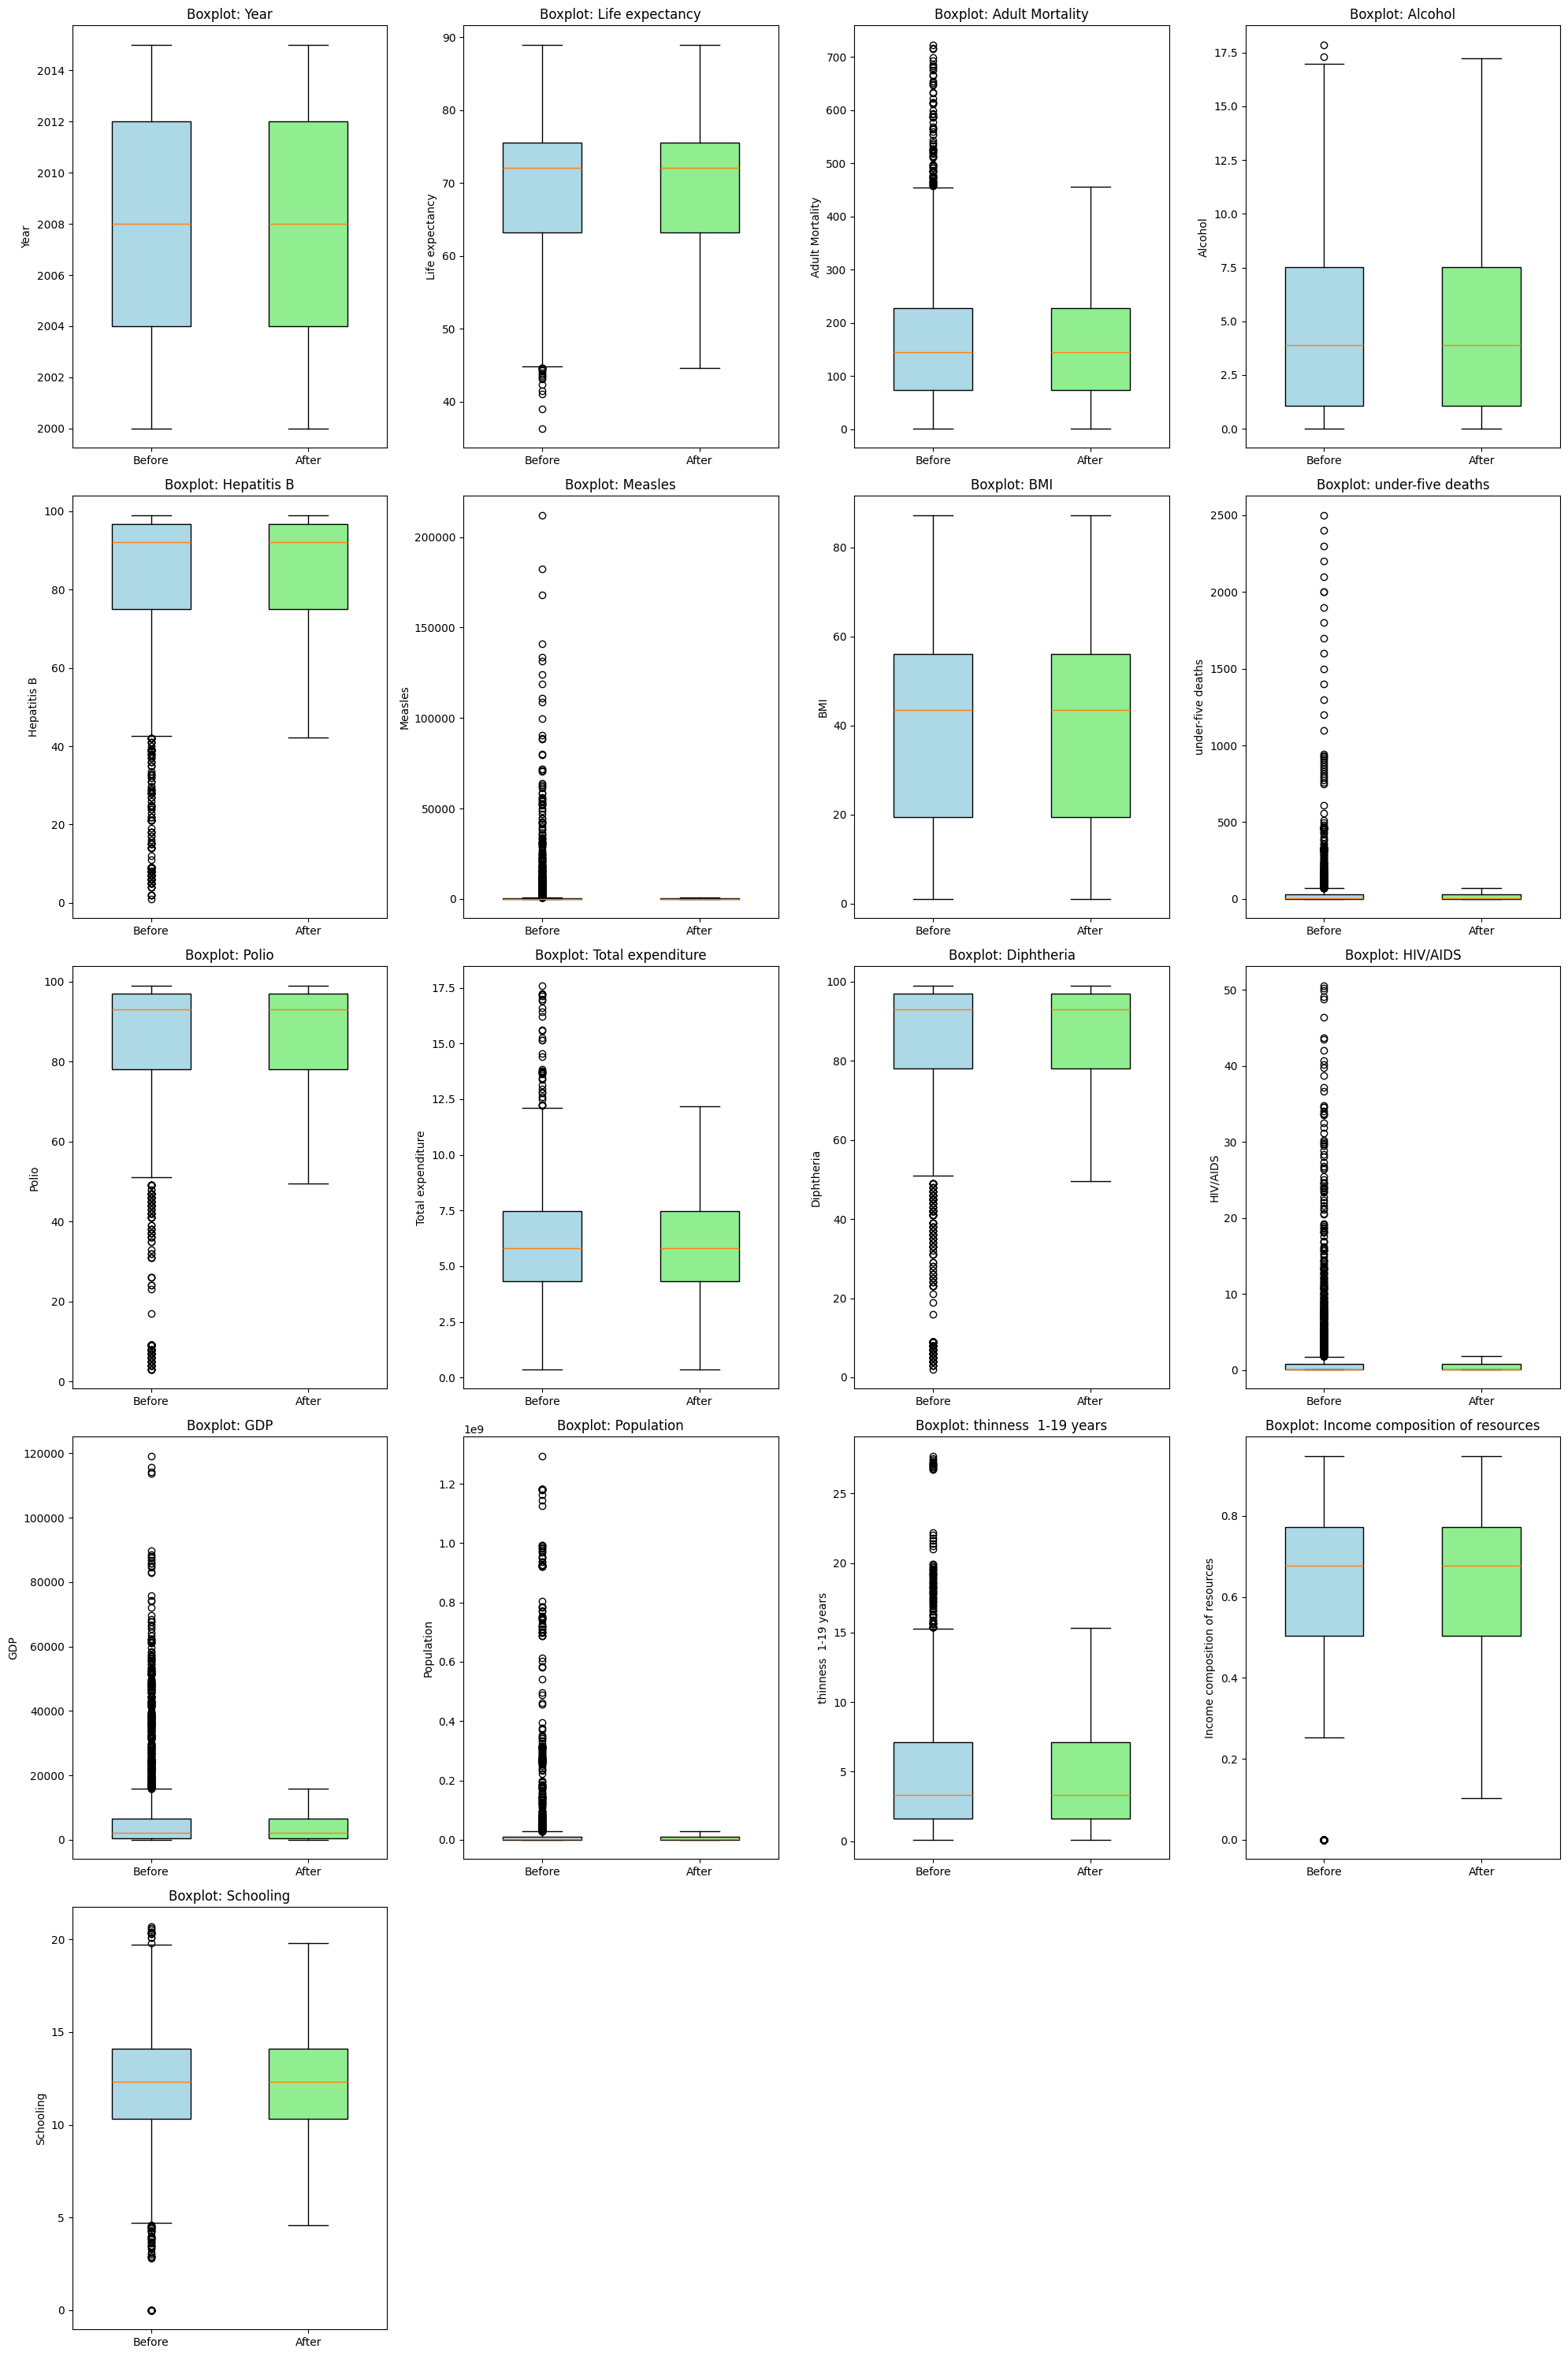

In [15]:
# Clean column names to remove leading/trailing spaces
df_who.columns = df_who.columns.str.strip()

# Update the list of numerical columns after cleaning column names
numerical_columns = df_who.select_dtypes(include=[np.number]).columns

# Backup the original data (before cleaning) for comparison
df_who_original = df_who.copy()

# Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR)
Q1 = df_who[numerical_columns].quantile(0.25)
Q3 = df_who[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Clean outliers by replacing values outside the lower/upper bounds with the bounds
for column in numerical_columns:
    lower_bound = Q1[column] - 1.5 * IQR[column]  # Lower bound for outliers
    upper_bound = Q3[column] + 1.5 * IQR[column]  # Upper bound for outliers
    df_who.loc[df_who[column] < lower_bound, column] = lower_bound  # Replace values below lower bound
    df_who.loc[df_who[column] > upper_bound, column] = upper_bound  # Replace values above upper bound

# Set the number of boxplots per row
plots_per_row = 4

# Get the number of numerical columns
num_columns = len(numerical_columns)

# Calculate the required number of rows for the subplots
num_rows = (num_columns + plots_per_row - 1) // plots_per_row

# Create subplots grid
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 6))
axes = axes.flatten()  # Flatten the grid to iterate over axes easily

# Iterate over numerical columns and plot boxplots
for i, column in enumerate(numerical_columns):
    ax = axes[i]  # Current subplot axis

    # Boxplot for original data (before cleaning)
    ax.boxplot(df_who_original[column], positions=[1], widths=0.5, patch_artist=True, 
               boxprops=dict(facecolor="lightblue"))
    # Boxplot for cleaned data (after cleaning)
    ax.boxplot(df_who[column], positions=[2], widths=0.5, patch_artist=True, 
               boxprops=dict(facecolor="lightgreen"))
    
    # Set the title and labels for the subplot
    ax.set_title(f'Boxplot: {column}')
    ax.set_ylabel(column)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before', 'After'])

# Hide unused subplot axes if there are extra slots in the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure plots fit well
plt.tight_layout()
plt.show()


In [16]:

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical column
Q1 = df_who[numerical_columns].quantile(0.25)
Q3 = df_who[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((df_who[numerical_columns] < (Q1 - 1.5 * IQR)) | (df_who[numerical_columns] > (Q3 + 1.5 * IQR)))

# Count the number of outliers in each numerical column
outlier_counts = outliers.sum()

print(outlier_counts)

Year                               0
Life expectancy                    0
Adult Mortality                    0
Alcohol                            0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
Income composition of resources    0
Schooling                          0
dtype: int64


### Encoding of Categorial Variables

The `Status` column, which categorizes countries as either "Developed" or "Developing," was one-hot encoded. This process converts the categorical variable into two binary columns:

- **`Status_Developed`**: Indicates whether a country is "Developed" (`1` for Developed, `0` otherwise).
- **`Status_Developing`**: Indicates whether a country is "Developing" (`1` for Developing, `0` otherwise).

By doing this, we ensure that the `Status` variable is represented numerically without introducing any ordinal assumptions, preserving the nature of the data.


In [17]:
# One-Hot Encoding for the Status column
status_encoded = pd.get_dummies(df_who['Status'], prefix='Status')

# Add the encoded columns to the DataFrame and drop the original Status column
df_who = pd.concat([df_who, status_encoded], axis=1)
df_who = df_who.drop(columns=['Status'])

# Ensure the one-hot encoded values are binary (0 or 1)
df_who = df_who.astype({col: 'int' for col in status_encoded.columns})

# Display the updated DataFrame
display(df_who)


,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
0,Afghanistan,2015,65.0,263.0,0.01,65.0,900.625,19.1,70,49.5,8.16,65.0,0.10,584.259210,2.780463e+07,15.35,0.479,10.1,0,1
1,Afghanistan,2014,59.9,271.0,0.01,62.0,492.000,18.6,70,58.0,8.18,62.0,0.10,612.696514,3.275820e+05,15.35,0.476,10.0,0,1
2,Afghanistan,2013,59.9,268.0,0.01,64.0,430.000,18.1,70,62.0,8.13,64.0,0.10,631.744976,2.780463e+07,15.35,0.470,9.9,0,1
3,Afghanistan,2012,59.5,272.0,0.01,67.0,900.625,17.6,70,67.0,8.52,67.0,0.10,669.959000,3.696958e+06,15.35,0.463,9.8,0,1
4,Afghanistan,2011,59.2,275.0,0.01,68.0,900.625,17.2,70,68.0,7.87,68.0,0.10,63.537231,2.978599e+06,15.35,0.454,9.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,456.5,4.36,68.0,31.000,27.1,42,67.0,7.13,65.0,1.85,454.366654,1.277751e+07,9.40,0.407,9.2,0,1
2934,Zimbabwe,2003,44.6,456.5,4.06,42.3,900.625,26.7,41,49.5,6.52,68.0,1.85,453.351155,1.263390e+07,9.80,0.418,9.5,0,1
2935,Zimbabwe,2002,44.8,73.0,4.43,73.0,304.000,26.3,40,73.0,6.53,71.0,1.85,57.348340,1.255250e+05,1.20,0.427,10.0,0,1
2936,Zimbabwe,2001,45.3,456.5,1.72,76.0,529.000,25.9,39,76.0,6.16,75.0,1.85,548.587312,1.236616e+07,1.60,0.427,9.8,0,1


The `Country` column contains 193 unique country names, making direct one-hot encoding impractical due to the high dimensionality it would introduce. To address this, countries were grouped by their respective continents (e.g., Europe, Asia, Africa, North America, South America, Oceania). This reduced the number of categories to six:

- **`Continent_Europe`**
- **`Continent_Asia`**
- **`Continent_Africa`**
- **`Continent_North America`**
- **`Continent_South America`**
- **`Continent_Oceania`**

This grouping preserves geographic context while minimizing complexity in the feature space.


In [18]:
def country_to_continent(country_name):
    try:
        # Convert country name to alpha-2 code
        country_code = pc.country_name_to_country_alpha2(country_name)
        # Convert country code to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Map continent codes to continent names
        continent_map = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continent_map.get(continent_code, 'Unknown')
    except:
        return 'Unknown'

# Apply the function to map countries to continents
df_who['Continent'] = df_who['Country'].apply(country_to_continent)

# One-Hot Encode the Continent column
continent_encoded = pd.get_dummies(df_who['Continent'], prefix='Continent')

# Add the encoded columns and drop the original Continent column
df_who = pd.concat([df_who, continent_encoded], axis=1)
df_who = df_who.drop(columns=['Continent'])

# Ensure all one-hot encoded values are integers
df_who = df_who.astype({col: 'int' for col in continent_encoded.columns})


In [19]:
df_who.columns

Index(['Country', 'Year', 'Life expectancy', 'Adult Mortality', 'Alcohol',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness  1-19 years', 'Income composition of resources', 'Schooling',
       'Status_Developed', 'Status_Developing', 'Continent_Africa',
       'Continent_Asia', 'Continent_Europe', 'Continent_North America',
       'Continent_Oceania', 'Continent_South America', 'Continent_Unknown'],
      dtype='object')

Check if it works properly

In [20]:
# Filter rows where Continent_Oceania is 1
oceania_countries = df_who[df_who['Continent_Oceania'] == 1]

# Print distinct country names
print("Countries in Oceania:")
print(oceania_countries['Country'].unique())

Countries in Oceania:
['Australia' 'Cook Islands' 'Fiji' 'Kiribati' 'Marshall Islands' 'Nauru'
 'New Zealand' 'Niue' 'Palau' 'Papua New Guinea' 'Samoa' 'Solomon Islands'
 'Tonga' 'Tuvalu' 'Vanuatu']


In [21]:
df_who.head()

,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,263.0,0.01,65.0,900.625,19.1,70,49.5,...,10.1,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,271.0,0.01,62.0,492.000,18.6,70,58.0,...,10.0,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,268.0,0.01,64.0,430.000,18.1,70,62.0,...,9.9,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,272.0,0.01,67.0,900.625,17.6,70,67.0,...,9.8,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,275.0,0.01,68.0,900.625,17.2,70,68.0,...,9.5,0,1,0,1,0,0,0,0,0


In [22]:
# Filter rows where Continent_Unknown is 1
unknown_continent_countries = df_who[df_who['Continent_Unknown'] == 1]

# Display the filtered rows
display(unknown_continent_countries)


,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
304,Bolivia (Plurinational State of),2015,77.0,186.0,0.576,99.0,0.000,52.6,10,99.0,...,13.8,0,1,0,0,0,0,0,0,1
305,Bolivia (Plurinational State of),2014,74.0,189.0,3.620,98.0,0.000,51.9,10,99.0,...,13.8,0,1,0,0,0,0,0,0,1
306,Bolivia (Plurinational State of),2013,71.0,192.0,3.780,94.0,0.000,51.2,10,95.0,...,13.8,0,1,0,0,0,0,0,0,1
307,Bolivia (Plurinational State of),2012,69.8,194.0,3.890,93.0,0.000,5.6,11,93.0,...,13.8,0,1,0,0,0,0,0,0,1
308,Bolivia (Plurinational State of),2011,69.3,198.0,3.930,95.0,0.000,49.9,11,95.0,...,13.8,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,Venezuela (Bolivarian Republic of),2004,73.3,161.0,7.550,82.0,0.000,55.9,11,83.0,...,11.6,0,1,0,0,0,0,0,0,1
2870,Venezuela (Bolivarian Republic of),2003,72.4,172.0,6.300,72.0,0.000,55.3,12,86.0,...,11.6,0,1,0,0,0,0,0,0,1
2871,Venezuela (Bolivarian Republic of),2002,73.1,167.0,6.890,42.3,900.625,54.7,12,81.0,...,11.0,0,1,0,0,0,0,0,0,1
2872,Venezuela (Bolivarian Republic of),2001,72.5,169.0,8.050,53.0,115.000,54.1,12,87.0,...,10.4,0,1,0,0,0,0,0,0,1


Check if unknown continents exist

In [23]:
# Filter rows where Continent_Unknown is 1
unknown_continent_countries = df_who[df_who['Continent_Unknown'] == 1]

# Get distinct country names
distinct_countries_unknown = unknown_continent_countries['Country'].unique()

# Print the distinct countries
print("Distinct countries with unknown continent:")
print(distinct_countries_unknown)


Distinct countries with unknown continent:
['Bolivia (Plurinational State of)' 'Iran (Islamic Republic of)'
 'Micronesia (Federated States of)' 'Republic of Korea'
 'The former Yugoslav republic of Macedonia' 'Timor-Leste'
 'Venezuela (Bolivarian Republic of)']


Define the manual mapping for countries in unknown continents

In [24]:
# Define the manual mapping for countries with unknown continents
manual_continent_mapping = {
    'Bolivia (Plurinational State of)': 'Continent_South America',
    'Iran (Islamic Republic of)': 'Continent_Asia',
    'Micronesia (Federated States of)': 'Continent_Oceania',
    'Republic of Korea': 'Continent_Asia',
    'The former Yugoslav republic of Macedonia': 'Continent_Europe',
    'Timor-Leste': 'Continent_Asia',
    'Venezuela (Bolivarian Republic of)': 'Continent_South America'
}

# Iterate over the mapping to correct one-hot encoded values
for country, continent_column in manual_continent_mapping.items():
    df_who.loc[df_who['Country'] == country, continent_column] = 1  # Set the correct continent column to 1
    df_who.loc[df_who['Country'] == country, 'Continent_Unknown'] = 0  # Ensure Continent_Unknown is set to 0


check if all countries are assigned to one continent

In [25]:
# Check if there are any rows with Continent_Unknown == 1
unknown_count = df_who[df_who['Continent_Unknown'] == 1]

# Display the rows with Continent_Unknown == 1 (if any)
if not unknown_count.empty:
    print("Countries still classified as 'Unknown':")
    display(unknown_count[['Country', 'Continent_Unknown']])
else:
    print("No countries are classified as 'Unknown'.")

# Check if any country is assigned to more than one continent
continent_columns = [col for col in df_who.columns if col.startswith('Continent_') and col != 'Continent_Unknown']
multiple_continents = df_who[continent_columns].sum(axis=1) > 1

# Check if any country is not assigned to any continent
no_continent = df_who[continent_columns].sum(axis=1) == 0

# Display rows with issues
if multiple_continents.any():
    print("Countries assigned to more than one continent:")
    display(df_who[multiple_continents][['Country'] + continent_columns])
else:
    print("No countries are assigned to more than one continent.")

if no_continent.any():
    print("Countries not assigned to any continent:")
    display(df_who[no_continent][['Country'] + continent_columns])
else:
    print("All countries are assigned to exactly one continent.")


No countries are classified as 'Unknown'.
No countries are assigned to more than one continent.
All countries are assigned to exactly one continent.


### Scaling for Machine Learning

In [26]:
# Select numerical columns to scale
numerical_columns = df_who.select_dtypes(include=['number']).columns

# Identify one-hot encoded columns (e.g., columns starting with 'Continent_' or 'Status_')
one_hot_columns = [col for col in numerical_columns if col.startswith('Continent_') or col.startswith('Status_')]
# Exclude 'Life expectancy' columns from encoding
one_hot_and_target = one_hot_columns + ['Life expectancy', 'Year']

# Identify numerical columns to scale (exclude one-hot encoded columns)
numerical_columns_to_scale = [col for col in numerical_columns if col not in one_hot_and_target]

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

# Create scaled DataFrames
scaled_dataframes = {}
standard_scaled = None
minmax_scaled = None
robust_scaled = None
maxabs_scaled = None

for scaler_name, scaler in scalers.items():
    scaled_df = df_who.copy()
    
    # Scale only the numerical columns excluding one-hot encoded columns
    scaled_df[numerical_columns_to_scale] = scaler.fit_transform(df_who[numerical_columns_to_scale])
    
    # Keep the one-hot encoded columns as they are
    scaled_dataframes[scaler_name] = scaled_df
    
    # Assign to specific variables for easy access
    if scaler_name == 'StandardScaler':
        standard_scaled_df = scaled_df
    elif scaler_name == 'MinMaxScaler':
        minmax_scaled_df = scaled_df
    elif scaler_name == 'RobustScaler':
        robust_scaled_df = scaled_df
    elif scaler_name == 'MaxAbsScaler':
        maxabs_scaled_df = scaled_df

# Display the scaled DataFrames
for scaler_name, scaled_df in scaled_dataframes.items():
    print(f"\nDataFrame scaled using {scaler_name}:\n")
    display(scaled_df)

# Variables holding specific scaled DataFrames
# standard_scaled_df, minmax_scaled_df, robust_scaled_df, maxabs_scaled_df



DataFrame scaled using StandardScaler:



,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,0.875099,-1.164162,-1.015802,1.886225,-0.967349,2.065644,-2.268402,...,-0.632374,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,0.944382,-1.164162,-1.183065,0.730456,-0.992434,2.065644,-1.730664,...,-0.664624,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,0.918400,-1.164162,-1.071557,0.555093,-1.017519,2.065644,-1.477611,...,-0.696875,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,0.953042,-1.164162,-0.904294,1.886225,-1.042605,2.065644,-1.161295,...,-0.729125,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,0.979023,-1.164162,-0.848540,1.886225,-1.062673,2.065644,-1.098031,...,-0.825876,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,2.550876,-0.064097,-0.848540,-0.573453,-0.565984,0.954102,-1.161295,...,-0.922627,0,1,1,0,0,0,0,0,0
2934,Zimbabwe,2003,44.6,2.550876,-0.139964,-2.281423,1.886225,-0.586052,0.914404,-2.268402,...,-0.825876,0,1,1,0,0,0,0,0,0
2935,Zimbabwe,2002,44.8,-0.770367,-0.046395,-0.569769,0.198710,-0.606120,0.874706,-0.781715,...,-0.664624,0,1,1,0,0,0,0,0,0
2936,Zimbabwe,2001,45.3,2.550876,-0.731723,-0.402506,0.835108,-0.626188,0.835008,-0.591925,...,-0.729125,0,1,1,0,0,0,0,0,0



DataFrame scaled using MinMaxScaler:



,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,0.575192,0.000000,0.400353,1.000000,0.209733,1.000000,0.000000,...,0.361842,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,0.592755,0.000000,0.347443,0.546287,0.203940,1.000000,0.171717,...,0.355263,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,0.586169,0.000000,0.382716,0.477446,0.198146,1.000000,0.252525,...,0.348684,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,0.594951,0.000000,0.435626,1.000000,0.192352,1.000000,0.353535,...,0.342105,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,0.601537,0.000000,0.453263,1.000000,0.187717,1.000000,0.373737,...,0.322368,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,1.000000,0.252375,0.453263,0.034421,0.302433,0.600000,0.353535,...,0.302632,0,1,1,0,0,0,0,0,0
2934,Zimbabwe,2003,44.6,1.000000,0.234970,0.000000,1.000000,0.297798,0.585714,0.000000,...,0.322368,0,1,1,0,0,0,0,0,0
2935,Zimbabwe,2002,44.8,0.158068,0.256436,0.541446,0.337543,0.293163,0.571429,0.474747,...,0.355263,0,1,1,0,0,0,0,0,0
2936,Zimbabwe,2001,45.3,1.000000,0.099210,0.594356,0.587370,0.288528,0.557143,0.535354,...,0.342105,0,1,1,0,0,0,0,0,0



DataFrame scaled using RobustScaler:



,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,0.777778,-0.597453,-1.238532,2.452811,-0.664850,2.357143,-2.289474,...,-0.578947,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,0.830065,-0.597453,-1.376147,1.318529,-0.678474,2.357143,-1.842105,...,-0.605263,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,0.810458,-0.597453,-1.284404,1.146426,-0.692098,2.357143,-1.631579,...,-0.631579,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,0.836601,-0.597453,-1.146789,2.452811,-0.705722,2.357143,-1.368421,...,-0.657895,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,0.856209,-0.597453,-1.100917,2.452811,-0.716621,2.357143,-1.315789,...,-0.736842,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,2.042484,0.074103,-1.100917,0.038862,-0.446866,1.357143,-1.368421,...,-0.815789,0,1,1,0,0,0,0,0,0
2934,Zimbabwe,2003,44.6,2.042484,0.027788,-2.279817,2.452811,-0.457766,1.321429,-2.289474,...,-0.736842,0,1,1,0,0,0,0,0,0
2935,Zimbabwe,2002,44.8,-0.464052,0.084909,-0.871560,0.796669,-0.468665,1.285714,-1.052632,...,-0.605263,0,1,1,0,0,0,0,0,0
2936,Zimbabwe,2001,45.3,2.042484,-0.333462,-0.733945,1.421235,-0.479564,1.250000,-0.894737,...,-0.657895,0,1,1,0,0,0,0,0,0



DataFrame scaled using MaxAbsScaler:



,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,0.576123,0.000580,0.656566,1.000000,0.218786,1.000000,0.500000,...,0.510101,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,0.593647,0.000580,0.626263,0.546287,0.213058,1.000000,0.585859,...,0.505051,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,0.587076,0.000580,0.646465,0.477446,0.207331,1.000000,0.626263,...,0.500000,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,0.595838,0.000580,0.676768,1.000000,0.201604,1.000000,0.676768,...,0.494949,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,0.602410,0.000580,0.686869,1.000000,0.197022,1.000000,0.686869,...,0.479798,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,1.000000,0.252809,0.686869,0.034421,0.310424,0.600000,0.676768,...,0.464646,0,1,1,0,0,0,0,0,0
2934,Zimbabwe,2003,44.6,1.000000,0.235413,0.427273,1.000000,0.305842,0.585714,0.500000,...,0.479798,0,1,1,0,0,0,0,0,0
2935,Zimbabwe,2002,44.8,0.159912,0.256867,0.737374,0.337543,0.301260,0.571429,0.737374,...,0.505051,0,1,1,0,0,0,0,0,0
2936,Zimbabwe,2001,45.3,1.000000,0.099732,0.767677,0.587370,0.296678,0.557143,0.767677,...,0.494949,0,1,1,0,0,0,0,0,0


Export the cleaned dataframes to csv

In [27]:
# # Directory of the output files
# output_dir = './data_postprocessing'
# os.makedirs(output_dir, exist_ok=True)

# # Save the dataframes to CSV files
# standard_scaled_df.to_csv(os.path.join(output_dir, 'standard_scaled_df.csv'), index=False)
# minmax_scaled_df.to_csv(os.path.join(output_dir, 'minmax_scaled_df.csv'), index=False)
# robust_scaled_df.to_csv(os.path.join(output_dir, 'robust_scaled_df.csv'), index=False)
# maxabs_scaled_df.to_csv(os.path.join(output_dir, 'maxabs_scaled_df.csv'), index=False)
# df_who.to_csv(os.path.join(output_dir, 'data.csv'), index=False)